### Load and Split Dataset & Calculate classes ratios

In [2]:
import os
import random
import numpy as np
import cv2

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation, ZeroPadding2D
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt

# Clear unused objects from memory
import gc
#gc.collect()

muslim_train = "data\\train\\muslim"
extra_muslim = "data\\train\\extra muslims"

chris_train = "data\\train\\chris"
chris_gen = "data\\train\\augs-chris"

muslim_val = "data\\val\\muslim"
chris_val = "data\\val\\chris"

muslim_test = "data\\test\\muslim"
chris_test=  "data\\test\\chris"




train_images = []
train_labels = []
val_images = []
val_labels = []
test_images = []
test_labels = []


def load_images_from_folder(folder_path, label, images_list, labels_list):
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.png')): 
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (64, 64)) 
                images_list.append(img)
                labels_list.append(label)

# Load images and labels for training and validation sets
load_images_from_folder(muslim_train, 0, train_images, train_labels)
load_images_from_folder(extra_muslim, 0, train_images, train_labels)
load_images_from_folder(muslim_val, 0, val_images, val_labels)
load_images_from_folder(muslim_test, 0, test_images, test_labels)

load_images_from_folder(chris_train, 1, train_images, train_labels)
load_images_from_folder(chris_gen, 1, train_images, train_labels)
load_images_from_folder(chris_val, 1, val_images, val_labels)
load_images_from_folder(chris_test, 1, test_images, test_labels)

# Convert to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)
val_images = np.array(val_images)
val_labels = np.array(val_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)



# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

train_dataset = (train_dataset
                 .shuffle(buffer_size=100)  
                 .batch(16)  
                 .prefetch(tf.data.experimental.AUTOTUNE))  

# Batch and prefetch validation dataset
val_dataset = val_dataset.batch(16).prefetch(tf.data.experimental.AUTOTUNE)

# Print number of images
print(f"Training images: {len(train_images)}")
print(f"Validation images: {len(val_images)}")
print(f"Test images: {len(test_images)}")
print("-----------------------------------------------------------")
# percentages of classes
train_percentages = 100 * np.bincount(train_labels) / len(train_labels)
val_percentages = 100 * np.bincount(val_labels) / len(val_labels)
test_percentages = 100 * np.bincount(test_labels) / len(test_labels)
for i, percentage in enumerate(train_percentages):
    print(f"Training Class {i}: {percentage:.2f}%")
print()
for i, percentage in enumerate(val_percentages):
    print(f"Validation Class {i}: {percentage:.2f}%")
for i, percentage in enumerate(test_percentages):
    print(f"Test Class {i}: {percentage:.2f}%")

Training images: 293
Validation images: 36
Test images: 36
-----------------------------------------------------------
Training Class 0: 50.85%
Training Class 1: 49.15%

Validation Class 0: 50.00%
Validation Class 1: 50.00%
Test Class 0: 50.00%
Test Class 1: 50.00%


### Plot sample of the Dataset ###

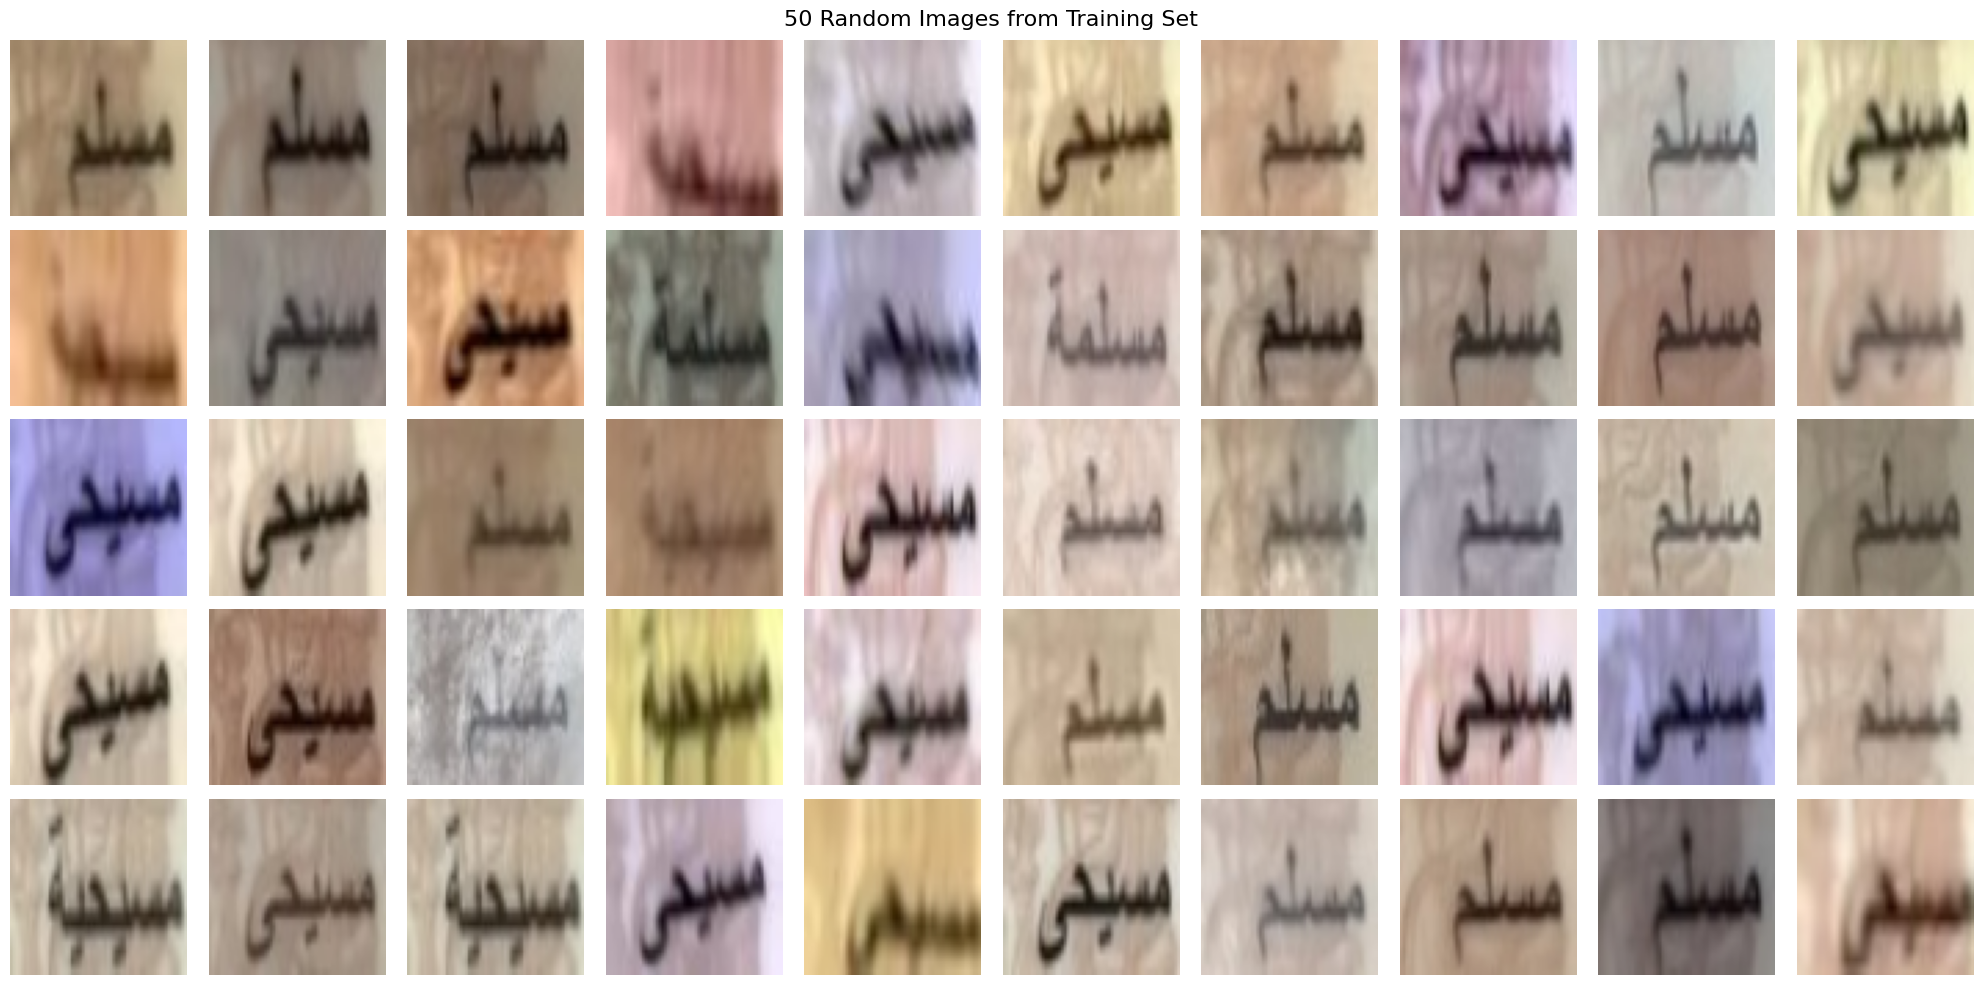

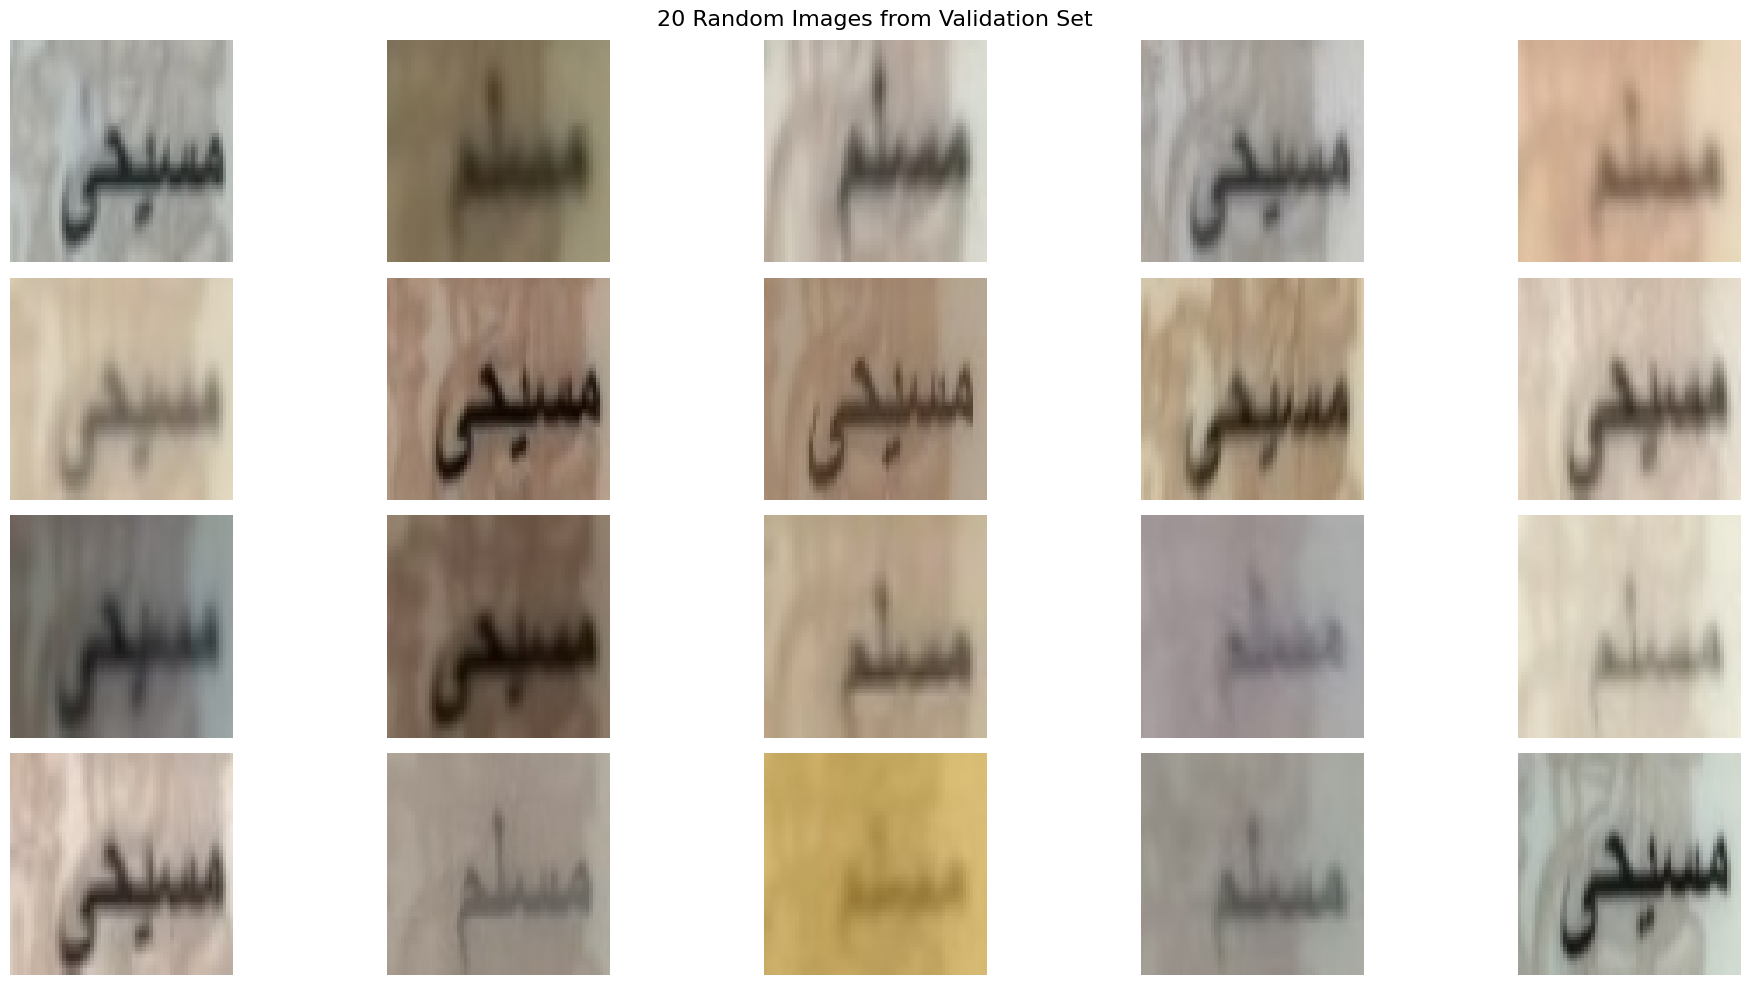

In [3]:
def plot_random_images(images, num_images, title, rows, cols):
    sample_indices = np.random.choice(len(images), num_images, replace=False)
    sample_images = images[sample_indices]
    
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(rows, cols, i+1)
        plt.imshow(cv2.cvtColor(sample_images[i], cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

plot_random_images(train_images, 50, '50 Random Images from Training Set', 5, 10)
plot_random_images(val_images, 20, '20 Random Images from Validation Set', 4, 5)


### Baseline Model: Simplle CNN 

In [4]:
def baseline_model(input_shape, l2_lambda=0.5):
    X_input = Input(input_shape)
    
    X = ZeroPadding2D((3, 3))(X_input)
    
    X = Conv2D(64, (3, 3), strides=(1, 1), kernel_regularizer=regularizers.l2(l2_lambda))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((2, 2))(X)
    
    X = Flatten()(X)
    X = Dropout(0.8)(X) 
    
    X = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(l2_lambda))(X)
    
    model = Model(inputs=X_input, outputs=X, name='GenderClassification')    
    return model

input_shape = (64, 64, 3)

religion_model = baseline_model(input_shape, l2_lambda=0.01)
religion_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

religion_model.summary()


Model: "GenderClassification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 70, 70, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 68, 68, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 68, 68, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 68, 68, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73984)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 73984)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        73,985 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,033 (297.00 KB)

 Trainable params: 75,905 (296.50 KB)

 Non-trainable params: 128 (512.00 B)

### Training

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import tensorflow.keras.backend as K

def lr_decay(epoch):
    initial_lr = 0.001 
    decay_factor = 0.5
    drop_every = 5  
    lr = initial_lr * (decay_factor ** (epoch // drop_every)) 
    return lr

early_stopping = EarlyStopping(monitor='val_accuracy',patience=10, min_delta=0.001,  restore_best_weights=True  )
lr_scheduler = LearningRateScheduler(lr_decay)

history = religion_model.fit(
    train_images, train_labels,
    epochs=100,                  
    validation_data=(val_images, val_labels),
    batch_size=16,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.5841 - loss: 1.9815 - val_accuracy: 0.9444 - val_loss: 0.3499 - learning_rate: 0.0010
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9665 - loss: 0.1908 - val_accuracy: 0.9444 - val_loss: 0.3805 - learning_rate: 0.0010
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9693 - loss: 0.1894 - val_accuracy: 0.9444 - val_loss: 0.3620 - learning_rate: 0.0010
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9986 - loss: 0.1205 - val_accuracy: 0.9167 - val_loss: 0.3506 - learning_rate: 0.0010
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.9862 - loss: 0.1378 - val_accuracy: 0.9167 - val_loss: 0.3709 - learning_rate: 0.0010
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9971 - loss: 0.1158 - val_accuracy: 0.9722 - val_loss: 0.1901 - learning_rate: 5.0000e-04
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9834 - loss: 0.133

### Evaluation Plot (val vs train)

Training Accuracy: 0.9965870380401611
Validation Accuracy: 1.0


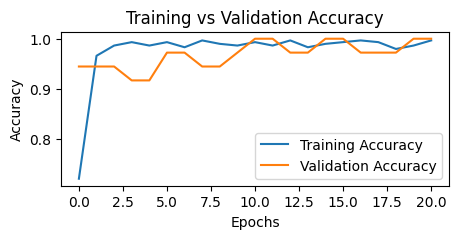

In [6]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

print("Training Accuracy:", training_accuracy[-1])  
print("Validation Accuracy:", validation_accuracy[-1]) 

# Plotting training and validation accuracy
plt.figure(figsize=(5, 2))
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Final Eval

In [7]:
# Step 1: Predictions and F1 Score calculation
val_predictions_prob = religion_model.predict(val_images)  
val_predictions = (val_predictions_prob > 0.5).astype(int) 

# Step 2: Calculate F1 score
f1 = f1_score(val_labels, val_predictions)
tn, fp, fn, tp = confusion_matrix(val_labels, val_predictions).ravel()



# Total errors (FP + FN)
total_error = fp + fn

# Calculate FN / Total Error and FP / Total Error
fp_over_total_error = fp / total_error if total_error != 0 else 'Inf'
fn_over_total_error = fn / total_error if total_error != 0 else 'Inf'

t1 = fp / (tp + tn + total_error) 
t2 = fn / (tp + tn + total_error )


# Print confusion matrix and additional metrics
print("True Negatives (TN):", tn)
print("False Positives (FP)*:", fp)
print("False Negatives (FN)*:", fn)
print("True Positives (TP):", tp)
print()

# Print FN/Total Error and FP/Total Error
#n("FP% from Error:", fp_over_total_error*100,"%")
#print("FN% from Error:", fn_over_total_error*100,"%")

#print()
#print("FP% from All data:", t1*100,"%")
#print("FN% from All data:", t2*100,"%")
#print()
# Print F1 score
print("f1-score:", f1)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
True Negatives (TN): 18
False Positives (FP)*: 0
False Negatives (FN)*: 0
True Positives (TP): 18

f1-score: 1.0


### TEST

In [8]:


test_predictions_prob = religion_model.predict(test_images)  
test_predictions = (test_predictions_prob > 0.5).astype(int) 

# Step 2: Calculate F1 score
f1 = f1_score(test_labels, test_predictions)
tn, fp, fn, tp = confusion_matrix(test_labels, test_predictions).ravel()

# Total errors (FP + FN)
total_error = fp + fn

# Calculate FN / Total Error and FP / Total Error
fp_over_total_error = fp / total_error if total_error != 0 else 'Inf'
fn_over_total_error = fn / total_error if total_error != 0 else 'Inf'

t1 = fp / (tp + tn + total_error) 
t2 = fn / (tp + tn + total_error )


# Print confusion matrix and additional metrics
print("True Negatives (TN):", tn)
print("False Positives (FP)*:", fp)
print("False Negatives (FN)*:", fn)
print("True Positives (TP):", tp)
print()

# Print FN/Total Error and FP/Total Error
print("FP% from Error:", fp_over_total_error*100,"%")
print("FN% from Error:", fn_over_total_error*100,"%")

print()
print("FP% from All data:", t1*100,"%")
print("FN% from All data:", t2*100,"%")
print()
# Print F1 score
print("f1-score:", f1)



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
True Negatives (TN): 18
False Positives (FP)*: 0
False Negatives (FN)*: 1
True Positives (TP): 17

FP% from Error: 0.0 %
FN% from Error: 100.0 %

FP% from All data: 0.0 %
FN% from All data: 2.7777777777777777 %

f1-score: 0.9714285714285714


### Save model & weights

In [11]:
#religion_model.save('religion_model_baseline_train_augs.keras')
#religion_model.save_weights('religion_model_baseline_train_augs.weights.h5')